In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, time, glob
import pyccl as ccl
import see_fits
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods/modules/')
import abundance as cl_count
import covariance as covar
import mvp_pdf
import edit
import model
from iminuit import Minuit
import forecast
import utils
import likelihood as l
import importance_sampling as imp_samp

real_cluster_abudance

In [2]:
true_value = [1,1]
x = np.linspace(1,10,10)
def model(theta):
    a, b = theta
    return a * x + b
mean = model(true_value)

In [3]:
mean

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [4]:
cov1 = np.zeros([len(x), len(x)])

In [5]:
A = 1
for i in range(len(x)):
    for j in range(len(x)):
        cov1[i,j] = A * np.exp(-abs(x[i]-x[j])**3)

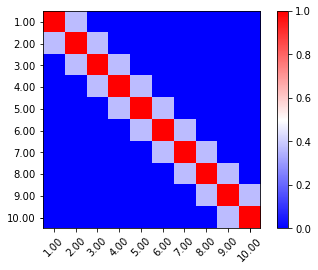

In [6]:
plt.imshow(cov1, cmap = 'bwr')
x_ticks = [f'{z:.2f}' for z in x]
index = np.arange(len(x))
index_split = np.split(index, 10)
ticks = [index_split[i][0] for i in range(10)]
ticks.append(len(x) - 1)
plt.xticks(ticks=ticks, labels=x_ticks, rotation = 45)
plt.yticks(ticks=ticks, labels=x_ticks)
plt.colorbar()

In [36]:
inv_cov1=np.linalg.inv(cov1)
inv_cov2=np.linalg.inv(cov1/2)

In [37]:
data_sample = np.random.multivariate_normal(mean, cov1, size=1000)

In [38]:
def lnL(data, theta, inv_cov):
    m=model(theta)
    return np.sum(.5*(data-m)*inv_cov.dot(data-m))

In [40]:
t={'1':[], '2':[]}
err={'1':[], '2':[]}
inv_cov=[inv_cov1,inv_cov2]
for d in data_sample:
    for i in range(2):
        def lnL_minuit(theta): return lnL(d, theta, inv_cov[i])
        m = Minuit(lnL_minuit,(1,1))
        m.migrad()
        t[str(i+1)].append(np.array(m.values))
        err[str(i+1)].append(np.array(m.errors))

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:8: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  


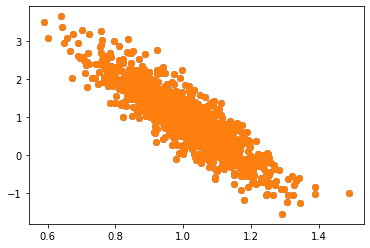

In [41]:
plt.scatter(np.array(t['2'])[:,0],np.array(t['2'])[:,1])
plt.scatter(np.array(t['1'])[:,0],np.array(t['1'])[:,1])

In [42]:
np.array(err['1'])[:,0]

array([0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763859,
       0.18763859, 0.18763859, 0.18763859, 0.18763859, 0.18763

(array([  309178.27794979,   772945.58874693,  1700480.52872385,
         8038634.1229681 , 34782556.2693515 , 77912926.04334737,
        23188367.66240799,  6647332.97592051,   772945.58874693,
          463767.41692469]),
 array([6.4630226 , 6.46302261, 6.46302261, 6.46302262, 6.46302263,
        6.46302263, 6.46302264, 6.46302264, 6.46302265, 6.46302266,
        6.46302266]),
 <a list of 10 Patch objects>)

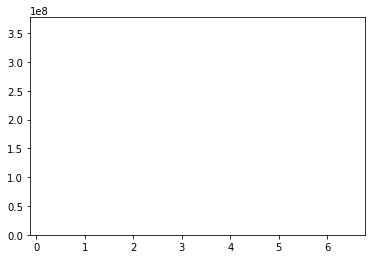

In [28]:
plt.hist(np.array(err['1'])[:,0], density=True)
plt.hist(np.array(err['2'])[:,1], density=True)

In [12]:
d_model=forecast.first_derivative(true_value, model, model(true_value).shape, delta = 1e-5)

In [13]:
def F(SigmaX, SigmaY, d_model):
    SigmaY_1 = np.linalg.inv(SigmaY)
    res=np.zeros([2,2])
    for i in range(2):
        for j in range(2):
            res[i,j] = np.sum(d_model[i,:] * np.dot( SigmaY_1, np.dot(SigmaX, SigmaY_1) ).dot(d_model[j,:]))
    return res

In [14]:
FXX = F(cov_full, cov_full, d_model)
FXY = F(cov_full, np.diag(cov_full.diagonal()), d_model)
FYX = F(np.diag(cov_full.diagonal()), cov_full, d_model)
FYY = F(np.diag(cov_full.diagonal()), np.diag(cov_full.diagonal()), d_model)

NameError: name 'cov_full' is not defined

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
utils._make_ellipse(true_value, np.linalg.inv(FXX), ax, level=0.95,n_sigma=1, color='k', label = r'$F_{XX}$', ls = '-')
utils._make_ellipse(true_value, np.linalg.inv(FXY), ax, level=0.95,n_sigma=1, color='r', label = r'$F_{XY}$', ls = '--')
utils._make_ellipse(true_value, np.linalg.inv(FYX), ax, level=0.95,n_sigma=1, color='g', label = r'$F_{YX}$', ls = '--')
utils._make_ellipse(true_value, np.linalg.inv(FYY), ax, level=0.95,n_sigma=1, color='b', label = r'$F_{YY}$', ls = '-')
ax.set_xlim(true_value[0]-.2, true_value[0]+.2)
ax.set_ylim(true_value[0]-1.5, true_value[1]+1.5)
ax.set_xlabel('a', fontsize=20)
ax.set_ylabel('b', fontsize=20)
ax.tick_params(axis='both', which = 'major', labelsize= 20)
ax.legend(fontsize=20, frameon=False)